In [1]:
import pandas as pd

otu_df = pd.read_csv('dataframes/OTU.txt', sep='\t')
hiera_blast = pd.read_csv('dataframes/hiera_BLAST.txt', sep='\t')
meta_map = pd.read_csv('dataframes/MCOSIS_map.txt', sep='\t')
meta = pd.read_csv('dataframes/antibiotics kazakh finished.csv', sep='\t')

In [2]:
meta = meta[['ID', 'sample', 'day of research', 'intervention', 'date of birth']]
meta_map_expanded = meta_map.set_index('#SampleID').fastqFile.str.split(',', expand=True).stack().reset_index(name='fastqFile').drop('level_1', axis=1)

# Соединение таблиц
merged = pd.merge(meta, meta_map_expanded, left_on='ID', right_on='fastqFile')

# Замена старых значений 'ID' на новые из '#SampleID'
meta['ID'] = merged['#SampleID']

# Показываем результат
meta.head()

,ID,sample,day of research,intervention,date of birth
0,SMPL0,1,40,yes,23.10.2012
1,SMPL1,1,45,yes,23.10.2012
2,SMPL2,1,50,yes,23.10.2012
3,SMPL3,1,55,yes,23.10.2012
4,SMPL4,1,60,yes,23.10.2012


In [3]:
meta_result = meta[meta['sample'].astype(str).str.contains('1|3|4', na=False)]
meta_result = meta_result[meta_result['day of research'].astype(str).str.contains('1|60', na=False)]
meta_result = meta_result[~meta_result['day of research'].astype(str).str.contains(r'\b10\b|\b15\b', na=False)]
meta_result = meta_result[~meta_result['ID'].astype(str).str.contains('SMPL78|SMPL80|SMPL68', na=False)]

meta_result

,ID,sample,day of research,intervention,date of birth
4,SMPL4,1,60,yes,23.10.2012
24,SMPL24,3,60,yes,19.11.2013
66,SMPL66,1,1,yes,23.10.2012
67,SMPL67,4,1,yes,19.05.2014
76,SMPL76,3,1,yes,19.11.2013
92,SMPL92,4,60,yes,19.05.2014


In [4]:
# Транспонирование otu_df
otu_df_transposed = otu_df.set_index('OTU').T
otu_df_transposed = otu_df_transposed.reset_index().rename(columns={'index': 'SampleID'})

# Переименование столбцов в meta_result для соответствия с otu_df_transposed
meta_result = meta_result.rename(columns={'ID': 'SampleID', 'intervention': 'GROUP'})

# Объединение таблиц
merged_df = pd.merge(meta_result, otu_df_transposed, on='SampleID')

# Переименование столбцов OTU
for col in merged_df.columns:
    if 'OTU' in col:
        merged_df = merged_df.rename(columns={col: col.replace('OTU_', 'OTU')})

# Вывод результата
merged_df = merged_df.drop(columns=['GROUP', 'date of birth'])
merged_df.to_csv('dataframes/output/otu/otu_starting.csv', sep='\t')
merged_df

,SampleID,sample,day of research,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,...,OTU4190,OTU4191,OTU4192,OTU4193,OTU4194,OTU4195,OTU4196,OTU4197,OTU4198,OTU4199
0,SMPL4,1,60,15,3,2,8,123,2,1,...,0,0,0,0,0,0,0,0,0,0
1,SMPL24,3,60,13,0,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SMPL66,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SMPL67,4,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SMPL76,3,1,8,0,1,0,155,0,0,...,0,0,0,0,0,0,0,0,0,0
5,SMPL92,4,60,4,1,0,0,17,0,87,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def modify_sample_id(row):
    if row['SampleID'] == 'SMPL4' and row['day of research'] == 60:
        return 'SMPL4_1_after'
    elif row['SampleID'] == 'SMPL66' and row['day of research'] == 1:
        return 'SMPL66_1_before'
    elif row['SampleID'] == 'SMPL24' and row['day of research'] == 60:
        return 'SMPL24_3_after'
    elif row['SampleID'] == 'SMPL76' and row['day of research'] == 1:
        return 'SMPL76_3_before'
    elif row['SampleID'] == 'SMPL67' and row['day of research'] == 1:
        return 'SMPL67_4_before'
    elif row['SampleID'] == 'SMPL92' and row['day of research'] == 60:
        return 'SMPL92_4_after'
    else:
        return row['SampleID']


merged_df['ModifiedSampleID'] = merged_df.apply(modify_sample_id, axis=1)
#merged_df = merged_df.drop(columns = ['sample', 'day of research'])
columns_order = ['SampleID', 'ModifiedSampleID'] + [col for col in merged_df.columns if col not in ['SampleID', 'ModifiedSampleID']]
merged_df = merged_df[columns_order]
merged_df

,SampleID,ModifiedSampleID,sample,day of research,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,...,OTU4190,OTU4191,OTU4192,OTU4193,OTU4194,OTU4195,OTU4196,OTU4197,OTU4198,OTU4199
0,SMPL4,SMPL4_1_after,1,60,15,3,2,8,123,2,...,0,0,0,0,0,0,0,0,0,0
1,SMPL24,SMPL24_3_after,3,60,13,0,36,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SMPL66,SMPL66_1_before,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SMPL67,SMPL67_4_before,4,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SMPL76,SMPL76_3_before,3,1,8,0,1,0,155,0,...,0,0,0,0,0,0,0,0,0,0
5,SMPL92,SMPL92_4_after,4,60,4,1,0,0,17,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
for col in hiera_blast.columns[1:]: 
    hiera_blast[col] = col[0].lower() + '_' + hiera_blast[col]

hiera_blast['OTU'] = hiera_blast['OTU'].str.replace('_', '')

hiera_blast['Taxonomy'] = hiera_blast['Domain'] + '|' + \
                        hiera_blast['Phylum'] + '|' + \
                        hiera_blast['Class'] + '|' + \
                        hiera_blast['Order'] + '|' + \
                        hiera_blast['Family'] + '|' + \
                        hiera_blast['Genus'] + '|' + \
                        hiera_blast['Species']

hiera_blast = hiera_blast[['OTU', 'Taxonomy']]

hiera_blast.head()

,OTU,Taxonomy
0,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...
1,OTU4149,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...
2,OTU4093,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...
3,OTU4078,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...
4,OTU4073,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...


In [7]:
long_merged_df = pd.melt(merged_df, id_vars=['SampleID','ModifiedSampleID'], var_name='OTU', value_name='Value')

# Объединяем hiera_blast с long_merged_df по столбцу 'OTU'
merged_result = pd.merge(hiera_blast, long_merged_df, on='OTU', how='inner')

In [8]:
merged_result_lacto_bifido = merged_result[merged_result['Taxonomy'].str.contains('Lactobacillales|Bifidobacteriales', na=False)]
merged_result_lacto_bifido

,OTU,Taxonomy,SampleID,ModifiedSampleID,Value
234,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL4,SMPL4_1_after,0
235,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL24,SMPL24_3_after,0
236,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL66,SMPL66_1_before,0
237,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL67,SMPL67_4_before,0
238,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL76,SMPL76_3_before,0
...,...,...,...,...,...
6043,OTU1602,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL24,SMPL24_3_after,0
6044,OTU1602,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL66,SMPL66_1_before,0
6045,OTU1602,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL67,SMPL67_4_before,0
6046,OTU1602,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL76,SMPL76_3_before,0


In [9]:
import pandas as pd

# Предполагается, что merged_result уже загружен в вашу среду выполнения

# Фильтрация для создания трёх разных таблиц
table1 = merged_result_lacto_bifido[merged_result_lacto_bifido['ModifiedSampleID'].isin(['SMPL66_1_before', 'SMPL4_1_after'])]
table2 = merged_result_lacto_bifido[merged_result_lacto_bifido['ModifiedSampleID'].isin(['SMPL76_3_before', 'SMPL24_3_after'])]
table3 = merged_result_lacto_bifido[merged_result_lacto_bifido['ModifiedSampleID'].isin(['SMPL67_4_before', 'SMPL92_4_after'])]

# Теперь у вас есть три таблицы: table1, table2, и table3
table1.head()

,OTU,Taxonomy,SampleID,ModifiedSampleID,Value
234,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL4,SMPL4_1_after,0
236,OTU3673,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL66,SMPL66_1_before,0
270,OTU3141,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL4,SMPL4_1_after,0
272,OTU3141,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL66,SMPL66_1_before,0
354,OTU2848,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,SMPL4,SMPL4_1_after,0


In [24]:
def to_pivot(df):
    data = df.copy()

    # Создание нового столбца 'Sample_Group'
    data['№'] = data['SampleID'] + '_' + data['ModifiedSampleID']

    # Создание сводной таблицы
    pivot_df = data.pivot_table(index='Taxonomy', columns='№', values='Value', aggfunc='sum', fill_value=0)

    # Сброс индекса, чтобы 'Taxonomy' стал столбцом
    pivot_df.reset_index(inplace=True)

    # Вывод первых нескольких строк полученного DataFrame для проверки
    return pivot_df

table1_pivot = to_pivot(table1)
table2_pivot = to_pivot(table2)
table3_pivot = to_pivot(table3)
table1_pivot.to_csv('dataframes/output/table1.csv', sep='\t')
table2_pivot.to_csv('dataframes/output/table2.csv', sep='\t')
table3_pivot.to_csv('dataframes/output/table3.csv', sep='\t')

In [22]:
table1_pivot_non_zero = table1_pivot[(table1_pivot['SMPL4_SMPL4_1_after'] != 0) | (table1_pivot['SMPL66_SMPL66_1_before'] != 0)]
table2_pivot_non_zero = table2_pivot[(table2_pivot['SMPL76_SMPL76_3_before'] != 0) | (table2_pivot['SMPL24_SMPL24_3_after'] != 0)]
table3_pivot_non_zero = table3_pivot[(table3_pivot['SMPL67_SMPL67_4_before'] != 0) | (table3_pivot['SMPL92_SMPL92_4_after'] != 0)]
table3_pivot_non_zero

№,Taxonomy,SMPL67_SMPL67_4_before,SMPL92_SMPL92_4_after
7,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,0,23
9,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,0,1
14,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,0,121
16,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,0,2


In [18]:
def rename_columns(column_name):
    # Разделяем имя столбца по '_'
    parts = column_name.split('_')
    # Удаляем дубликаты, сохраняя порядок
    unique_parts = []
    for part in parts:
        if part not in unique_parts:
            unique_parts.append(part)
    # Объединяем обратно в строку
    return '_'.join(unique_parts)

# Изменение имён столбцов
table1_pivot_non_zero.columns = [rename_columns(col) for col in table1_pivot_non_zero.columns]
table2_pivot_non_zero.columns = [rename_columns(col) for col in table2_pivot_non_zero.columns]
table3_pivot_non_zero.columns = [rename_columns(col) for col in table3_pivot_non_zero.columns]
table1_pivot_non_zero.head()

,Taxonomy,SMPL66_1_before,SMPL4_1_after
8,g_Enterococcus,1,0
9,g_Lactobacillus,0,4
14,g_Streptococcus,0,5


In [13]:
def reorder_columns(df):
    # Сортируем столбцы, начинающиеся на 'before'
    before_cols = sorted([col for col in df.columns if '_before' in col])
    # Сортируем столбцы, начинающиеся на 'after'
    after_cols = sorted([col for col in df.columns if '_after' in col])
    # Собираем столбцы, не содержащие 'before' или 'after'
    other_cols = [col for col in df.columns if col not in before_cols + after_cols]
    # Объединяем все в правильном порядке
    return df[other_cols + before_cols + after_cols]

# Применение функции к DataFrame
table1_pivot_non_zero = reorder_columns(table1_pivot_non_zero)
table2_pivot_non_zero = reorder_columns(table2_pivot_non_zero)
table3_pivot_non_zero = reorder_columns(table3_pivot_non_zero)

# Проверка результата
table1_pivot_non_zero


,Taxonomy,SMPL66_1_before,SMPL4_1_after
8,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,1,0
9,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,0,4
14,d_Bacteria|p_Firmicutes|c_Bacilli|o_Lactobacil...,0,5


In [14]:
def clean_and_extract_last_taxa(taxonomy):
    # Удаление частей, оканчивающихся на '_?'
    cleaned_parts = [part for part in taxonomy.split('|') if not part.endswith('_?')]
    # Возврат последнего элемента из очищенных частей
    return cleaned_parts[-1] if cleaned_parts else ''

# Применение функции к столбцу 'Taxonomy'
table1_pivot_non_zero['Taxonomy'] = table1_pivot_non_zero['Taxonomy'].apply(clean_and_extract_last_taxa)
table2_pivot_non_zero['Taxonomy'] = table2_pivot_non_zero['Taxonomy'].apply(clean_and_extract_last_taxa)
table3_pivot_non_zero['Taxonomy'] = table3_pivot_non_zero['Taxonomy'].apply(clean_and_extract_last_taxa)
# Объединение всех трёх DataFrame в один
combined_df = pd.concat([table1_pivot_non_zero, table2_pivot_non_zero, table3_pivot_non_zero])
combined_df = combined_df.fillna(0)
# Проверка результата
combined_df


,Taxonomy,SMPL66_1_before,SMPL4_1_after,SMPL76_3_before,SMPL24_3_after,SMPL67_4_before,SMPL92_4_after
8,g_Enterococcus,1.0,0.0,0.0,0.0,0.0,0.0
9,g_Lactobacillus,0.0,4.0,0.0,0.0,0.0,0.0
14,g_Streptococcus,0.0,5.0,0.0,0.0,0.0,0.0
14,g_Streptococcus,0.0,0.0,1.0,0.0,0.0,0.0
7,g_Granulicatella,0.0,0.0,0.0,0.0,0.0,23.0
9,g_Lactobacillus,0.0,0.0,0.0,0.0,0.0,1.0
14,g_Streptococcus,0.0,0.0,0.0,0.0,0.0,121.0
16,s_Streptococcus parasanguinis CC87K,0.0,0.0,0.0,0.0,0.0,2.0











Таксон: g_Enterococcus, p-value: 0.4226
Таксон: g_Lactobacillus, p-value: 0.3469
Таксон: g_Streptococcus, p-value: 0.7837
Таксон: g_Granulicatella, p-value: 0.4226
Таксон: s_Streptococcus parasanguinis CC87K, p-value: 0.4226





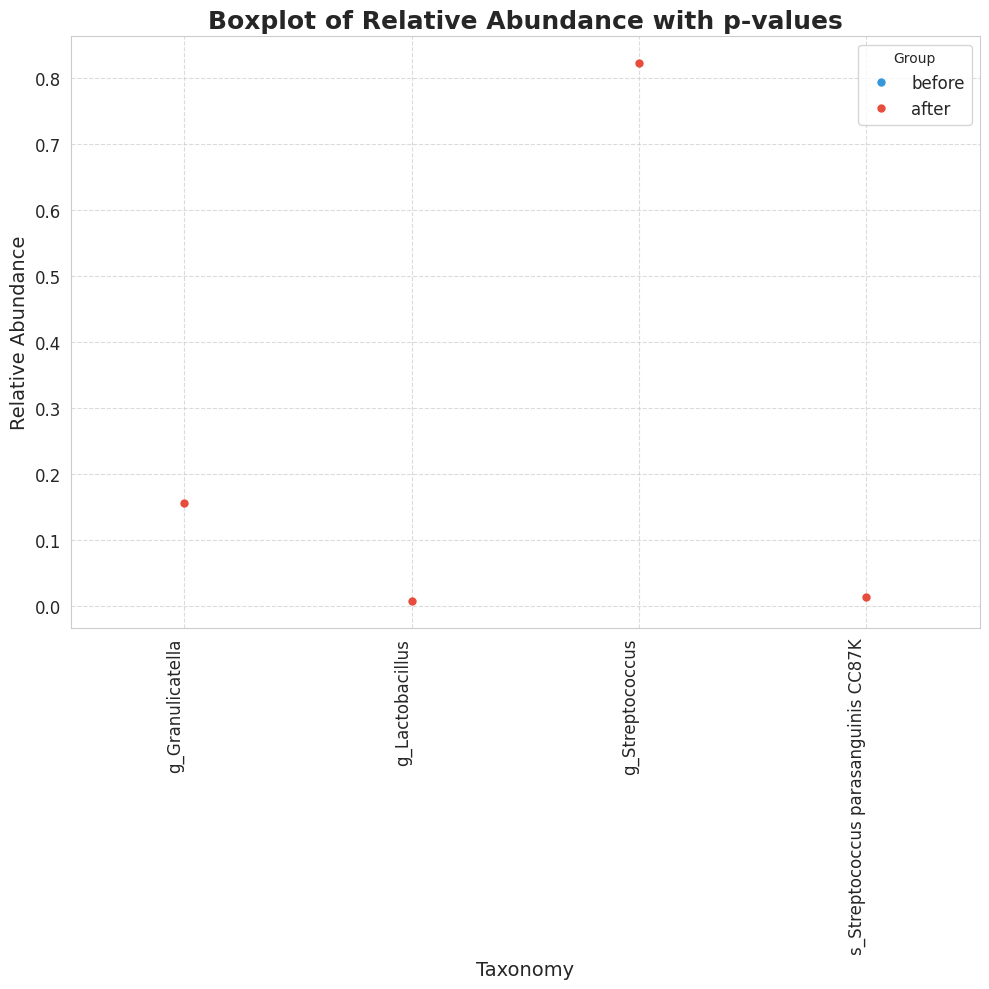

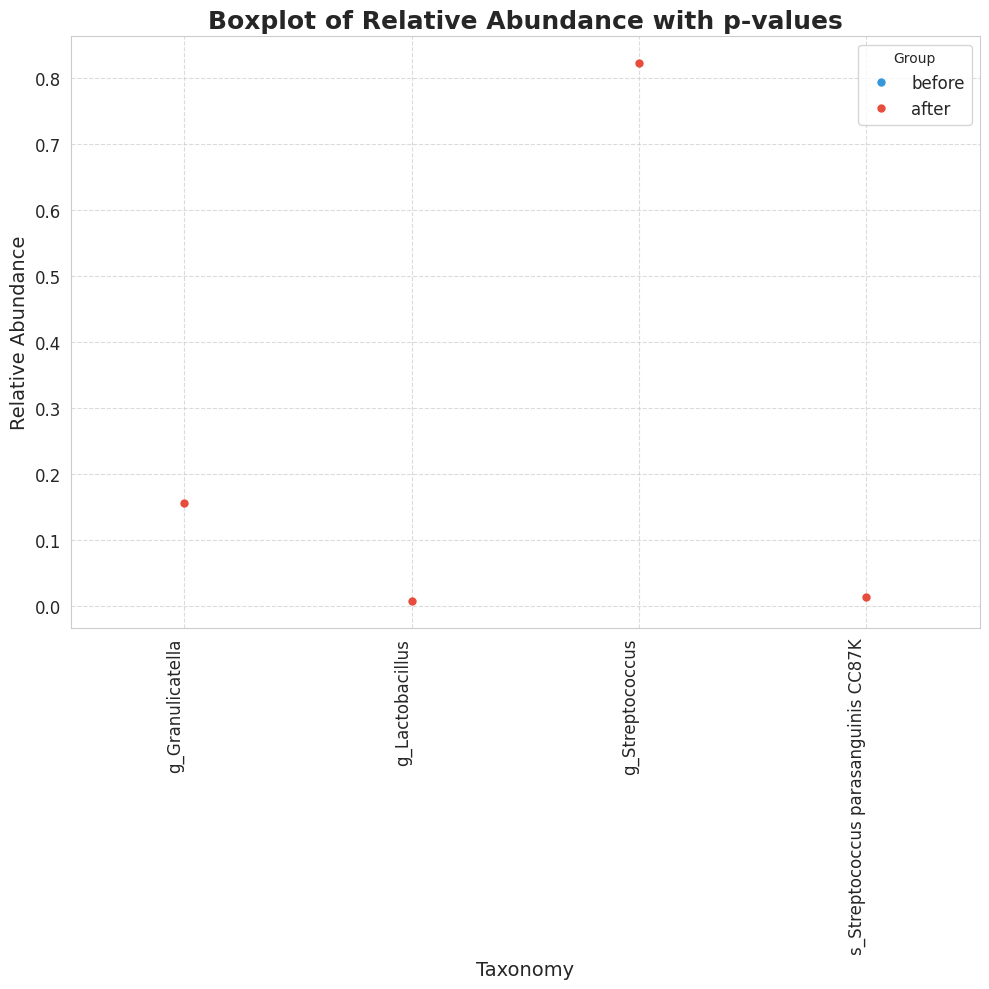

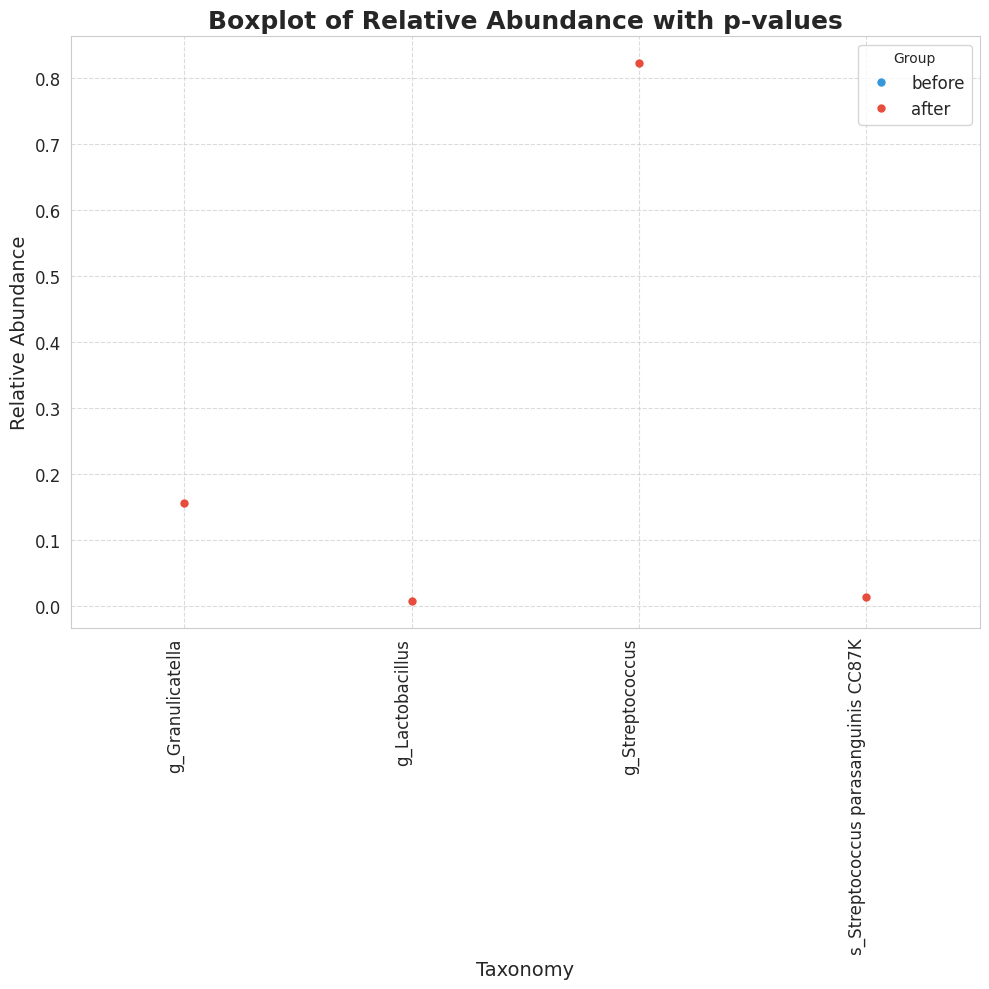

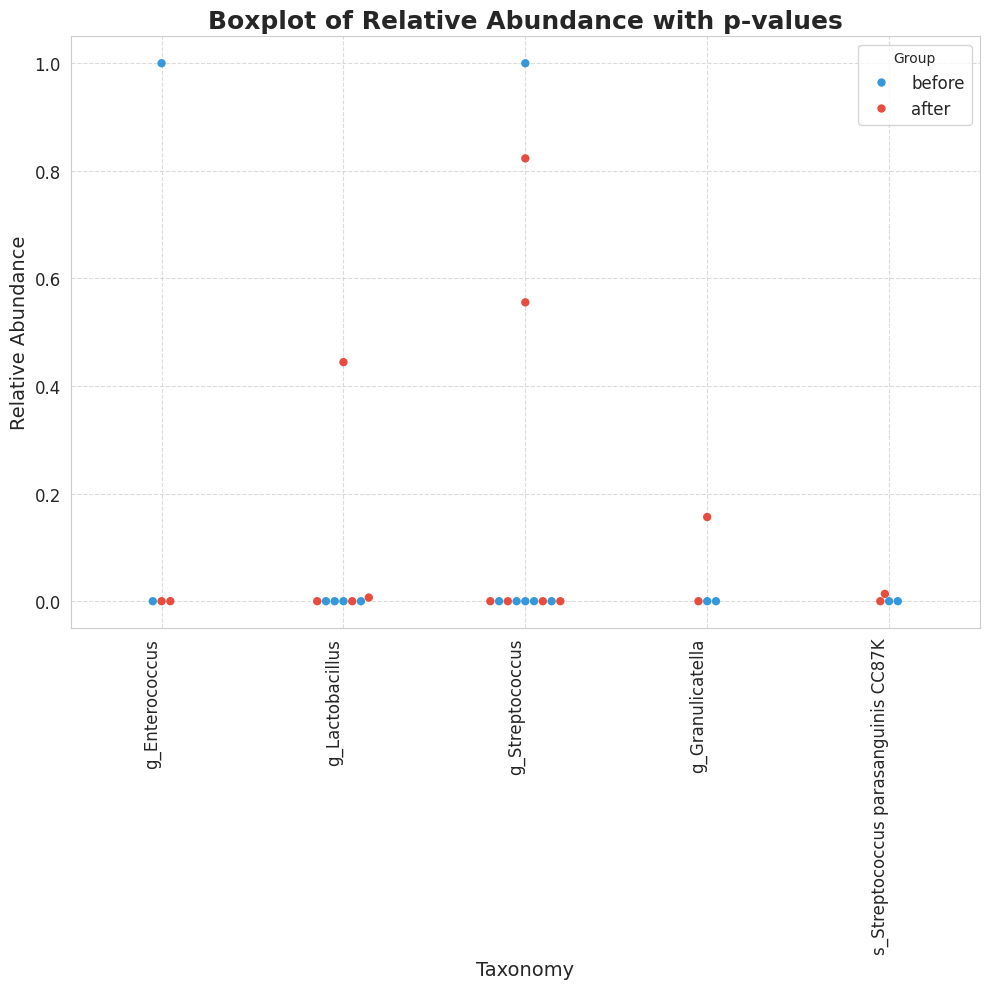

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def visual_boxplot(df):
    # Шаг 1: Расчёт относительного изобилия
    sample_columns = [col for col in df.columns if col != 'Taxonomy']
    df[sample_columns] = df[sample_columns].div(df[sample_columns].sum(), axis=1)

    # Шаг 2: Переупорядочивание столбцов
    ordered_columns = ['Taxonomy'] + sample_columns
    df = df[ordered_columns]

    # Шаг 3: Перевод в "длинный" формат
    melted_df = df.melt(id_vars='Taxonomy', var_name='Sample', value_name='Relative Abundance')

    # Шаг 4: Определение групп
    melted_df['Group'] = melted_df['Sample'].apply(lambda x: 'before' if 'before' in x else 'after')

    # Настройка визуализации
    sns.set_style("whitegrid")
    flierprops = dict(marker='o', markerfacecolor='black', markersize=6, linestyle='none')

    # Расчёт p-значений
    significant_taxa = {}
    for taxon in melted_df['Taxonomy'].unique():
        before_values = melted_df[(melted_df['Taxonomy'] == taxon) & (melted_df['Group'] == 'before')]['Relative Abundance']
        after_values = melted_df[(melted_df['Taxonomy'] == taxon) & (melted_df['Group'] == 'after')]['Relative Abundance']
        
        if len(before_values) > 1 and len(after_values) > 1:
            t_stat, p_val = ttest_ind(before_values, after_values, nan_policy='omit')
#            if p_val < 0.05
            significant_taxa[taxon] = p_val

    # Фильтрация для значимых таксонов
    significant_melted_df = melted_df[melted_df['Taxonomy'].isin(significant_taxa.keys())]
    colors = ['#3498db', '#e74c3c']
    # Визуализация
    palette = {'before': '#3498db', 'after': '#e74c3c'}
    plt.figure(figsize=(10, 10))
    ax = sns.swarmplot(x='Taxonomy', y='Relative Abundance', hue='Group', data=melted_df, palette=palette, size=6)

    # Добавление p-значений
    # for i, taxon in enumerate(significant_melted_df['Taxonomy'].unique()):
    #     p_val = significant_taxa.get(taxon)
    #     if p_val:  # Если таксон значим
    #         # Вычисление медианы относительного изобилия для таксона
    #         median_abundance = np.median(significant_melted_df[significant_melted_df['Taxonomy'] == taxon]['Relative Abundance'])
    #         # Расчет координаты y для текста
    #         y_text = median_abundance + 0.015  # Сдвигаем текст на 5% выше медианы
    #         plt.text(i, y_text, f"{p_val:.3f}", ha='center', color="red", size=14)
    # Оформление графика
    plt.xticks(rotation=90, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Taxonomy', fontsize=14)
    plt.ylabel('Relative Abundance', fontsize=14)
    plt.title('Boxplot of Relative Abundance with p-values', fontsize=18, fontweight='bold')
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.legend(loc="upper right", fontsize=12, title="Group")
    plt.tight_layout()
    for taxon, p_val in significant_taxa.items():
        print(f"Таксон: {taxon}, p-value: {p_val:.4f}")
    print('\n\n')

visual_boxplot(table3_pivot_non_zero)
visual_boxplot(table3_pivot_non_zero)
visual_boxplot(table3_pivot_non_zero)
visual_boxplot(combined_df)


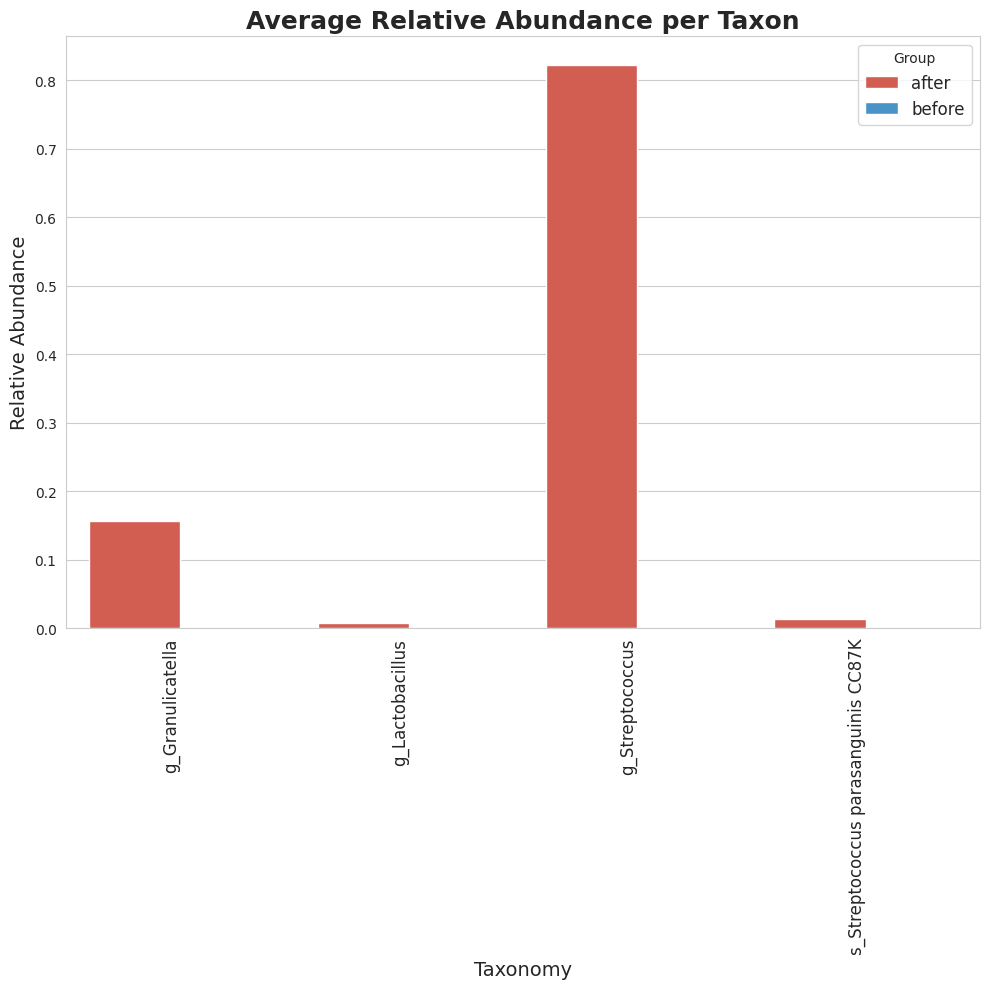

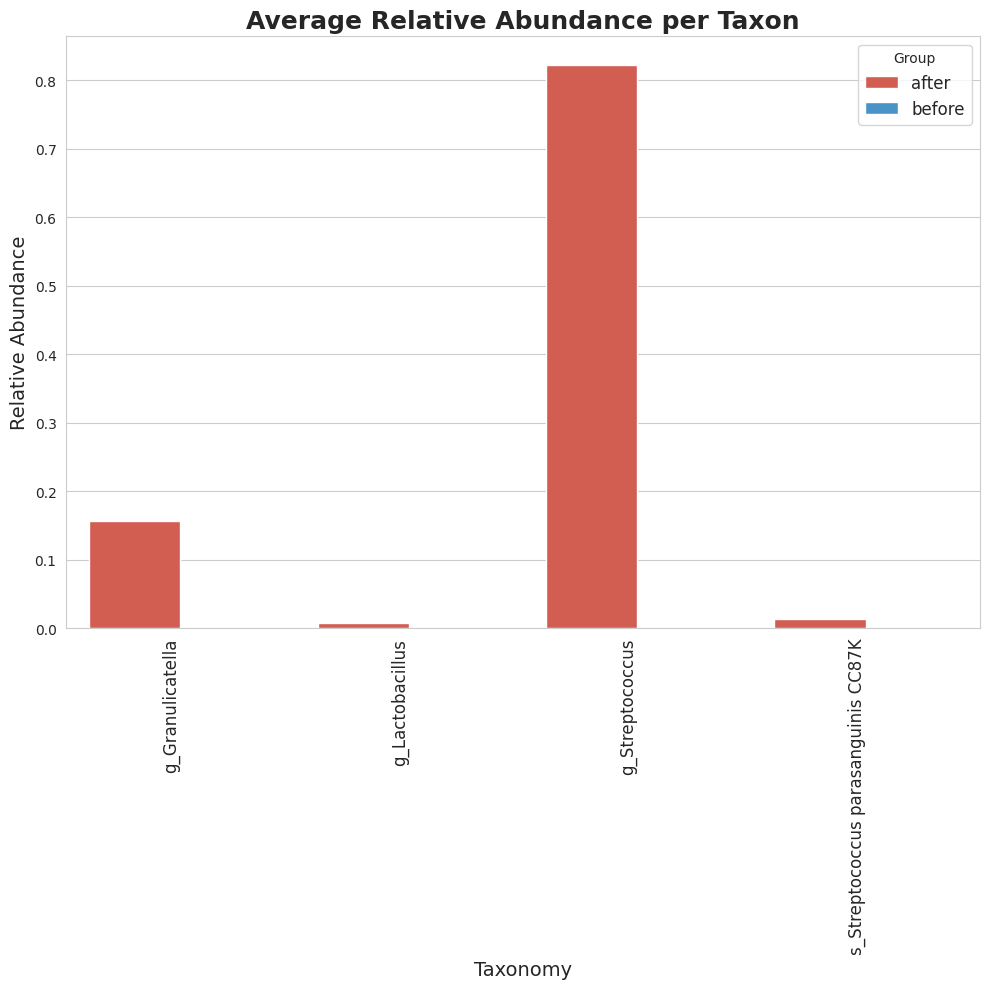

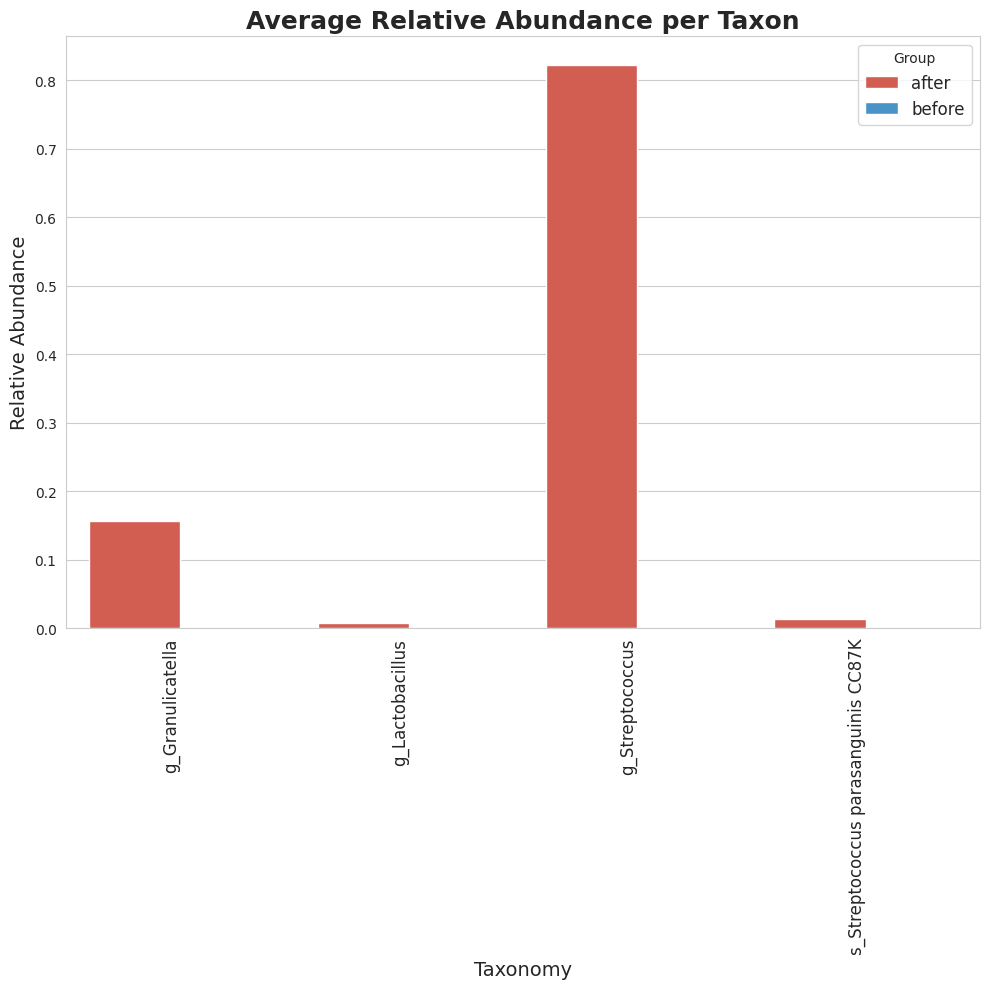

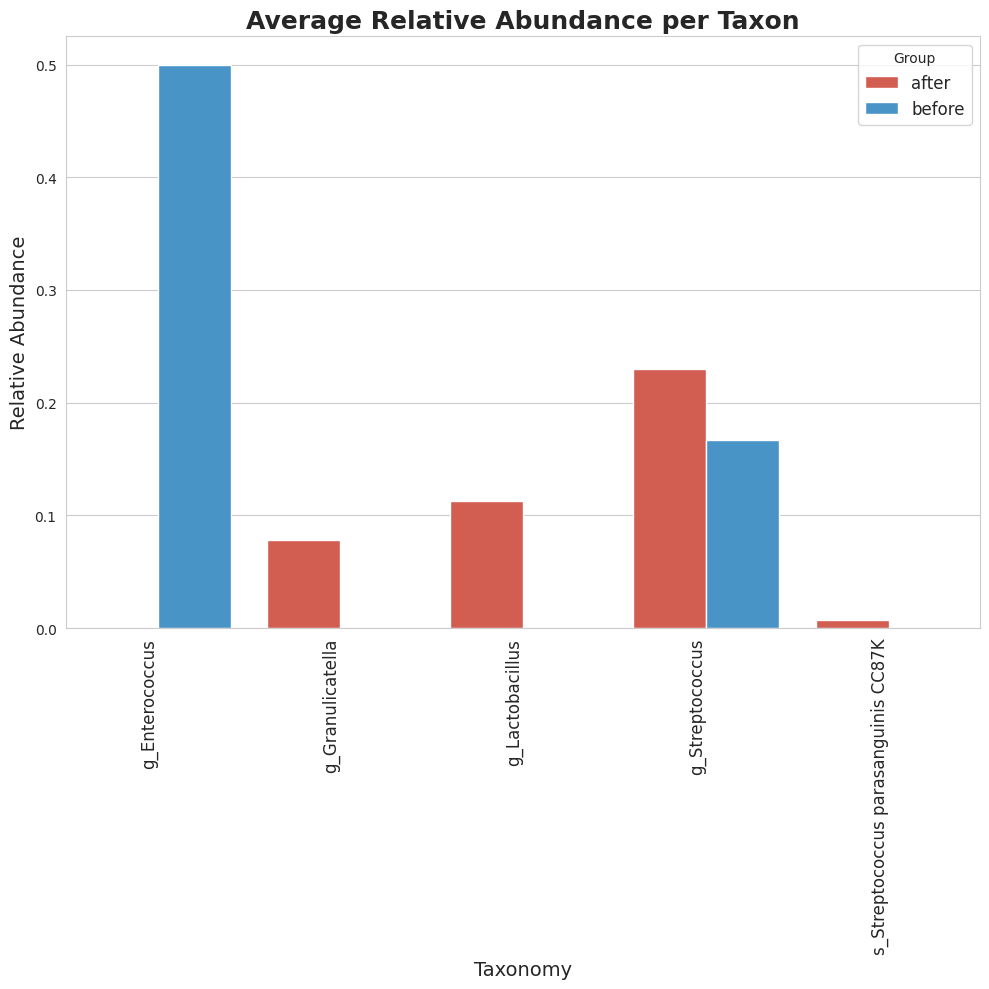

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def visual_barplot(df):
    # Шаг 1: Расчёт относительного изобилия
    sample_columns = [col for col in df.columns if col != 'Taxonomy']
    df[sample_columns] = df[sample_columns].div(df[sample_columns].sum(), axis=1)

    # Шаг 2: Переупорядочивание столбцов
    ordered_columns = ['Taxonomy'] + sample_columns
    df = df[ordered_columns]

    # Шаг 3: Перевод в "длинный" формат
    melted_df = df.melt(id_vars='Taxonomy', var_name='Sample', value_name='Relative Abundance')

    # Шаг 4: Определение групп
    melted_df['Group'] = melted_df['Sample'].apply(lambda x: 'before' if 'before' in x else 'after')

    # Подготовка данных для визуализации
    group_means = melted_df.groupby(['Taxonomy', 'Group'])['Relative Abundance'].mean().reset_index()

    # Настройка визуализации
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 10))

    # Визуализация с помощью вертикальной столбчатой диаграммы
    sns.barplot(x='Taxonomy', y='Relative Abundance', hue='Group', data=group_means, palette=[ '#e74c3c', '#3498db'])

    # Оформление графика
    plt.xticks(rotation=90, ha='right', fontsize=12)
    plt.xlabel('Taxonomy', fontsize=14)
    plt.ylabel('Relative Abundance', fontsize=14)
    plt.title('Average Relative Abundance per Taxon', fontsize=18, fontweight='bold')
    plt.legend(title='Group', loc='upper right', fontsize=12)
    plt.tight_layout()

    plt.show()


visual_barplot(table3_pivot_non_zero)
visual_barplot(table3_pivot_non_zero)
visual_barplot(table3_pivot_non_zero)
visual_barplot(combined_df)
